# Multi-task learning: Multiple inputs
![jupyter](https://www.pyimagesearch.com/wp-content/uploads/2019/02/keras_multi_input_header.png)


## How can Keras accept multiple inputs?

![jupyter](https://www.pyimagesearch.com/wp-content/uploads/2019/02/keras_multi_input_functional_api.jpg)
As opposed to its Sequential API, Keras’ functional API allows for much more complex models. In this blog post we use the functional API to support our goal of creating a model with multiple inputs and mixed data for house price prediction.


Keras is able to handle multiple inputs (and even multiple outputs) via its functional API.

The functional API, as opposed to the sequential API (which you almost certainly have used before via the Sequential
  class), can be used to define much more complex models that are non-sequential, including:

    - Multi-input models
    
    - Multi-output models
    
    - Models that are both multiple input and multiple output
    
    - Directed acyclic graphs
    
    - Models with shared layers

##  A   Multi-task learning (2 inputs and 1 output)

### 1 Data Preprocessing  -  import the necessary libraries

before load the data, you should install the following modules

1. pip install -U scikit-learn
2. pip install keras
3. pip install numpy
4. pip install argparse 
5. pip install matplotlib
6. pip install pandas

or you can select the environment in Anaconda, and select the necessary library to install

if you want to see the framework of model constrcting you have to install the libraries,
1. sudo apt-get insall graphviz or conda install graphviz
2. pip install pydot==1.2.3
3. pip install pydot-ng 

if it appears "AttributeError: module 'os' has no attribute 'errno'", 
please reference:
https://stackoverflow.com/questions/51852502/error-message-when-using-pydot-to-save-image-attributeerror-module-os-has-no

In [1]:
from sklearn.model_selection import train_test_split
from keras.layers.core import Dense
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import concatenate
import numpy as np
import argparse
import locale
import os
import pickle

Using TensorFlow backend.


### 1 Data Preprocessing  - load data from file

house_data.pkl contains text information and image information

In [8]:
with open('house_data.pkl', 'rb') as file:
    all_data = pickle.load(file)
    
df             = all_data['text_inf']      # text information
images         = all_data['image_inf']     # image information

print(df)
print(images.shape)

     bedrooms  bathrooms  area  zipcode    price
30          5        3.0  2520    93446   789000
32          3        2.0  1802    93446   365000
39          3        3.0  2146    93446   455000
80          4        2.5  2464    91901   599000
81          2        2.0  1845    91901   529800
..        ...        ...   ...      ...      ...
499         4        4.0  3000    93446  1495000
500         3        2.0  2330    93446   599900
501         3        2.5  1339    93446   344900
502         3        2.0  1472    93446   309995
503         4        4.0  2681    93446   572000

[362 rows x 5 columns]
(362, 64, 64, 3)


## 1 Data Preprocessing  -  data processing

In [2]:
from sklearn.preprocessing import MinMaxScaler,LabelBinarizer

def process_house_attributes(df, train, test):
    # initialize the column names of the continuous data
    continuous = ["bedrooms", "bathrooms", "area"]

    # performin min-max scaling each continuous feature column to
    # the range [0, 1]
    cs = MinMaxScaler()
    trainContinuous = cs.fit_transform(train[continuous])
    testContinuous = cs.transform(test[continuous])

    # one-hot encode the zip code categorical data (by definition of
    # one-hot encoing, all output features are now in the range [0, 1])
    zipBinarizer = LabelBinarizer().fit(df["zipcode"])
    trainCategorical = zipBinarizer.transform(train["zipcode"])
    testCategorical = zipBinarizer.transform(test["zipcode"])

    # construct our training and testing data points by concatenating
    # the categorical features with the continuous features
    trainX = np.hstack([trainCategorical, trainContinuous])
    testX = np.hstack([testCategorical, testContinuous])

    # return the concatenated training and testing data
    return (trainX, testX)

In [11]:
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
print("[INFO] processing data...")
split = train_test_split(df, images, test_size=0.25, random_state=42)
(trainAttrX, testAttrX, trainImagesX, testImagesX) = split

# find the largest house price in the training set and use it to
# scale our house prices to the range [0, 1] (will lead to better
# training and convergence)
maxPrice = trainAttrX["price"].max()
trainY = trainAttrX["price"] / maxPrice
testY = testAttrX["price"] / maxPrice

# process the house attributes data by performing min-max scaling
# on continuous features, one-hot encoding on categorical features,
# and then finally concatenating them together
(trainAttrX, testAttrX) = process_house_attributes(df, trainAttrX, testAttrX)

print(trainAttrX.shape)
print(testAttrX.shape)
print(trainY.shape)
print(testY.shape)
print(trainImagesX.shape)
print(testImagesX.shape)

[INFO] processing data...
(271, 10)
(91, 10)
(271,)
(91,)
(271, 64, 64, 3)
(91, 64, 64, 3)


### 2 Building the model


For example, we define a simple sequential neural network as: 10D inputs, a first hidden layer with 8 nodes, a second hidden layer with 4 nodes, and a final output layer used for regression.

In [12]:
from keras.models import Sequential
from keras.layers import Dense, Activation

model = Sequential()
model.add(Dense(8, input_shape=(10,), activation="relu"))
model.add(Dense(4, activation="relu"))
model.add(Dense(1, activation="linear"))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8)                 88        
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5         
Total params: 129
Trainable params: 129
Non-trainable params: 0
_________________________________________________________________


#### We can define the simple neural network using the functional API:

In [13]:
from keras.layers import Input, Dense, concatenate
from keras.models import Model

inputs = Input(shape=(10,))
x = Dense(8, activation="relu")(inputs)
x = Dense(4, activation="relu")(x)
x = Dense(1, activation="linear")(x)
model = Model(inputs, x)

#### To see the power of Keras’ function API consider the following code where we create a model that accepts multiple inputs:

In [14]:
inputA = Input(shape=(32,))     ################# different inputs for two branches #####################
inputB = Input(shape=(128,))    ################# different inputs for two branches #####################

# the first branch operates on the first input
x = Dense(8, activation="relu")(inputA)    ## the first input
x = Dense(4, activation="relu")(x)
x = Model(inputs=inputA, outputs=x)

# the second branch opreates on the second input
y = Dense(64, activation="relu")(inputB)   ## the second input
y = Dense(32, activation="relu")(y)
y = Dense(4, activation="relu")(y)
y = Model(inputs=inputB, outputs=y)

# combine the output of the two branches
combined = concatenate([x.output, y.output])  ################# Concatenate between X and Y #####################

# apply a FC layer and then a regression prediction on the
# combined outputs
z = Dense(2, activation="relu")(combined)
z = Dense(1, activation="linear")(z)
# our model will accept the inputs of the two branches and
# then output a single value
model = Model(inputs=[x.input, y.input], outputs=z)

## summary the mode
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 128)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 32)           0                                            
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 64)           8256        input_3[0][0]                    
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 8)            264         input_2[0][0]                    
____________________________________________________________________________________________

Here you can see we are defining two inputs to our Keras neural network:

    - inputA: 32-dim
    
    - inputB: 128-dim

After defining two networks, we  combine the outputs of both the x  and y. The outputs of x and y are both 4-dim so once we concatenate them we have a 8-dim vector.

We then apply two more fully-connected layers. The first layer has 2 nodes followed by a ReLU activation while the second layer has only a single node with a linear activation (i.e., our regression prediction).

The final step to building the multi-input model is to define a Model  object which:

    - Accepts our two inputs
    
    - Defines the outputs as the final set of FC layers (i.e., z).
 
 If you were to use Keras to visualize the model architecture it would look like the following:
![jupyter](https://www.pyimagesearch.com/wp-content/uploads/2019/02/keras_multi_input_arch.png)

### 3 Complie the model


In [8]:
opt = Adam(lr=1e-3, decay=1e-3 / 200)
model.compile(loss="mean_absolute_percentage_error", optimizer=opt, metrics=["mse"])

### 4 Fit the model

In [9]:
## fit the model
hist = model.fit(
    [np.random.rand(271,32), np.random.rand(271,128)], trainY,
    validation_data=([np.random.rand(91,32), np.random.rand(91,128)], testY),
    epochs=50, batch_size=8)


Train on 271 samples, validate on 91 samples
Epoch 1/50
271/271 [==============================] - 1s 3ms/step - loss: 76.7457 - mse: 0.0142 - val_loss: 70.9762 - val_mse: 0.0089
Epoch 2/50
271/271 [==============================] - 0s 814us/step - loss: 66.9039 - mse: 0.0128 - val_loss: 71.2262 - val_mse: 0.0093
Epoch 3/50
271/271 [==============================] - 0s 1ms/step - loss: 67.0700 - mse: 0.0133 - val_loss: 71.5783 - val_mse: 0.0095
Epoch 4/50
271/271 [==============================] - 0s 898us/step - loss: 67.0699 - mse: 0.0129 - val_loss: 71.3279 - val_mse: 0.0094
Epoch 5/50
271/271 [==============================] - 0s 909us/step - loss: 66.9458 - mse: 0.0133 - val_loss: 71.5667 - val_mse: 0.0095
Epoch 6/50
271/271 [==============================] - 0s 739us/step - loss: 67.2003 - mse: 0.0132 - val_loss: 70.9425 - val_mse: 0.0090
Epoch 7/50
271/271 [==============================] - 0s 1ms/step - loss: 66.9270 - mse: 0.0130 - val_loss: 71.7855 - val_mse: 0.0096
Epoch 8/

### 5 Evaluation

In [10]:
## Evaluation the model
print("[INFO] predicting house prices...")
preds = model.predict([np.random.rand(91,32), np.random.rand(91,128)])

[INFO] predicting house prices...


### 6 Test

In [11]:
## Test the model

diff = preds.flatten() - testY
percentDiff = (diff / testY) * 100
absPercentDiff = np.abs(percentDiff)

# compute the mean and standard deviation of the absolute percentage
# difference
mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)

# finally, show some statistics on our model
locale.setlocale(locale.LC_ALL, "en_US.UTF-8")
print("[INFO] avg. house price: {}, std house price: {}".format(
	locale.currency(df["price"].mean(), grouping=True),
	locale.currency(df["price"].std(), grouping=True)))
print("[INFO] mean: {:.2f}%, std: {:.2f}%".format(mean, std))

[INFO] avg. house price: $533,388.27, std house price: $493,403.08
[INFO] mean: 71.22%, std: 22.22%


## Defining our Multi-layer Perceptron (MLP) and Convolutional Neural Network (CNN)



![jupyter](https://pyimagesearch.com/wp-content/uploads/2019/02/keras_multi_input_design.png)
Our Keras multi-input + mixed data model has one branch that accepts the numerical/categorical data (left) and another branch that accepts image data in the form a 4-photo montage (right).


In order to build our multi-input network we will need two branches:

    - The first branch will be a simple Multi-layer Perceptron (MLP) designed to handle the categorical/numerical inputs.
    
    - The second branch will be a Convolutional Neural Network to operate over the image data.
    
    - These branches will then be concatenated together to form the final multi-input Keras model.

We’ll handle building the final concatenated multi-input model in the next section — our current task is to define the two branches.

## Loading the image dataset

In [12]:
print(trainImagesX.shape)
print(testImagesX.shape)

(271, 64, 64, 3)
(91, 64, 64, 3)


###  model construction

Our categorical/numerical data will be processed by a simple Multi-layer Perceptron (MLP).

- A fully connected (Dense) input layer with ReLU activation.

- A fully-connected hidden layer, also with ReLU activation.

- An optional regression output with linear activation.
While we used the regression output of the MLP in the first post, it will not be used in this multi-input, mixed data network. As you’ll soon see, we’ll be setting regress=False explicitly even though it is the default as well. Regression will actually be performed later on the head of the entire multi-input, mixed data network.

In [15]:
from keras.models import Sequential,Model
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D,MaxPooling2D
from keras.layers.core import Activation,Dropout,Dense
from keras.layers import Flatten,Input

def create_mlp(dim, regress=False):
    # define our MLP network
    model = Sequential()
    model.add(Dense(8, input_dim=dim, activation="relu"))
    model.add(Dense(4, activation="relu"))

    # check to see if the regression node should be added
    if regress:
        model.add(Dense(1, activation="linear"))

    # return our model
    return model

def create_cnn(width, height, depth, filters=(16, 32, 64), regress=False):
    # initialize the input shape and channel dimension, assuming
    # TensorFlow/channels-last ordering
    inputShape = (height, width, depth)
    chanDim = -1

    # define the model input
    inputs = Input(shape=inputShape)

    # loop over the number of filters
    for (i, f) in enumerate(filters):
        # if this is the first CONV layer then set the input
        # appropriately
        if i == 0:
            x = inputs

        # CONV => RELU => BN => POOL
        x = Conv2D(f, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)

    # flatten the volume, then FC => RELU => BN => DROPOUT
    x = Flatten()(x)
    x = Dense(16)(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = Dropout(0.5)(x)

    # apply another FC layer, this one to match the number of nodes
    # coming out of the MLP
    x = Dense(4)(x)
    x = Activation("relu")(x)

    # check to see if the regression node should be added
    if regress:
        x = Dense(1, activation="linear")(x)

    # construct the CNN
    model = Model(inputs, x)

    # return the CNN
    return model

Combine the constructed MLP model and CNN model

In [16]:
from keras.utils import plot_model
# create the MLP and CNN models
mlp = create_mlp(trainAttrX.shape[1], regress=False)
cnn = create_cnn(64, 64, 3, regress=False)

# create the input to our final set of layers as the *output* of both
# the MLP and CNN
combinedInput = concatenate([mlp.output, cnn.output])

# our final FC layer head will have two dense layers, the final one
# being our regression head
x = Dense(4, activation="relu")(combinedInput)
x = Dense(1, activation="linear")(x)

# our final model will accept categorical/numerical data on the MLP
# input and images on the CNN input, outputting a single value (the
# predicted price of the house)
model = Model(inputs=[mlp.input, cnn.input], outputs=x)

model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 16)   448         input_4[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 64, 64, 16)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 64, 64, 16)   64          activation_1[0][0]               
____________________________________________________________________________________________

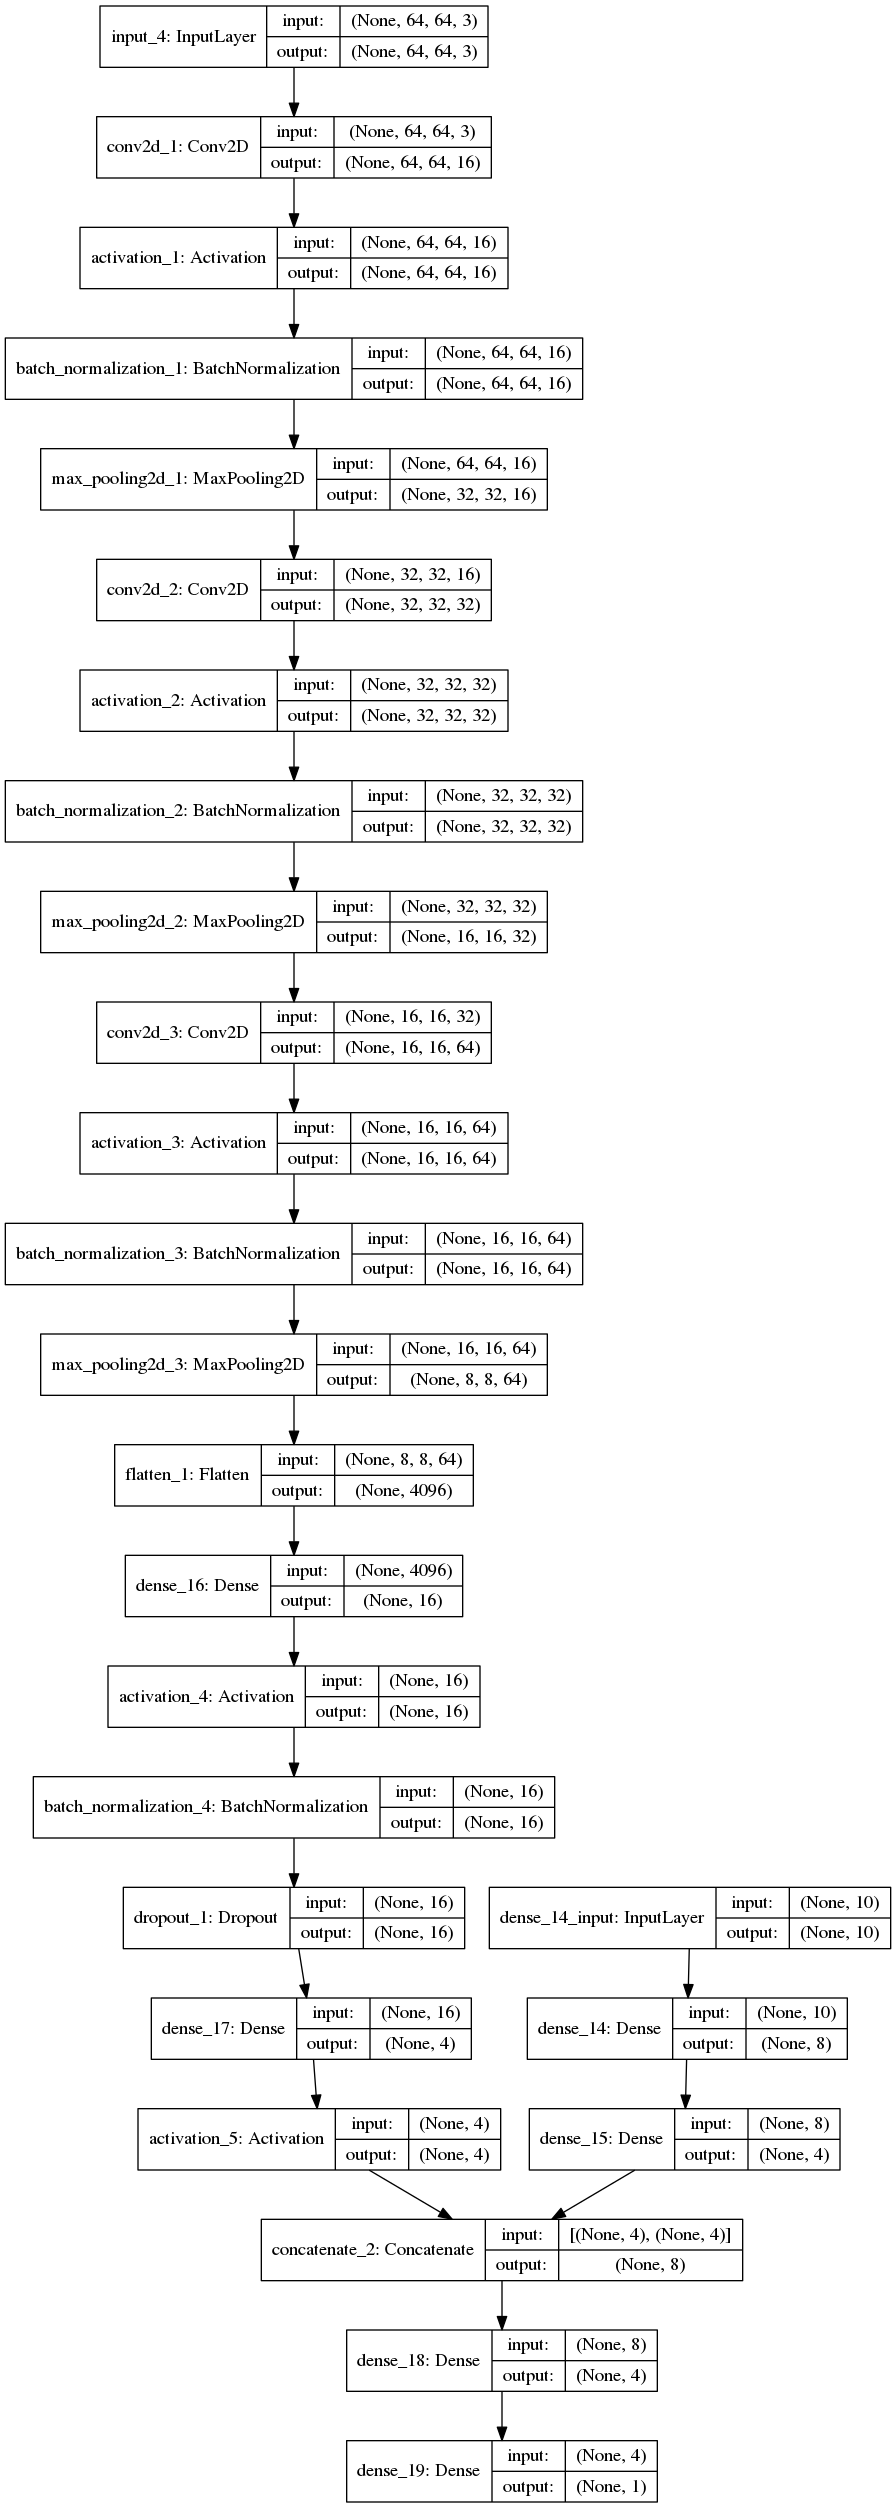

In [15]:
plot_model(model, to_file='model1.png', show_shapes='True')

## 5 model compilation

In [17]:
# compile the model using mean absolute percentage error as our loss,
# implying that we seek to minimize the absolute percentage difference
# between our price *predictions* and the *actual prices*
opt = Adam(lr=1e-3, decay=1e-3 / 200)
model.compile(loss="mean_absolute_percentage_error", optimizer=opt, metrics=["mse"])

## 6 model training

In [17]:
# train the model
print("[INFO] training model...")
hist = model.fit(
    [trainAttrX, trainImagesX], trainY,
    validation_data=([testAttrX, testImagesX], testY),
    epochs=50, batch_size=8)

[INFO] training model...
Train on 271 samples, validate on 91 samples
Epoch 1/50
271/271 [==============================] - 3s 10ms/step - loss: 579.5447 - mse: 0.1091 - val_loss: 358.3201 - val_mse: 0.0404
Epoch 2/50
271/271 [==============================] - 1s 2ms/step - loss: 375.6147 - mse: 0.0628 - val_loss: 170.8604 - val_mse: 0.0087
Epoch 3/50
271/271 [==============================] - 1s 2ms/step - loss: 229.2415 - mse: 0.0422 - val_loss: 69.0017 - val_mse: 0.0077
Epoch 4/50
271/271 [==============================] - 1s 2ms/step - loss: 172.1439 - mse: 0.0260 - val_loss: 71.3556 - val_mse: 0.0079
Epoch 5/50
271/271 [==============================] - 1s 2ms/step - loss: 108.9352 - mse: 0.0200 - val_loss: 76.5752 - val_mse: 0.0060
Epoch 6/50
271/271 [==============================] - 1s 2ms/step - loss: 99.8223 - mse: 0.0180 - val_loss: 336.1039 - val_mse: 0.0493
Epoch 7/50
271/271 [==============================] - 1s 2ms/step - loss: 79.7556 - mse: 0.0130 - val_loss: 365.0101 

## 6 visualization

In [18]:
# list all data in history
print(hist.history.keys())

dict_keys(['val_loss', 'val_mse', 'loss', 'mse'])


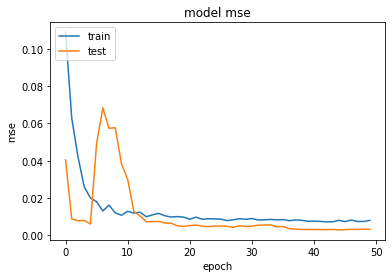

In [19]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.figure()
plt.plot(hist.history['mse'])
plt.plot(hist.history['val_mse'])
plt.title('model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

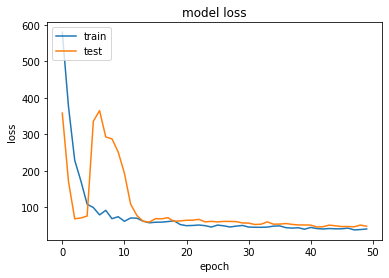

In [20]:
# summarize history for loss value
plt.figure()
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## 7 prediction

In [21]:
# make predictions on the testing data
print("[INFO] predicting house prices...")
preds = model.predict([testAttrX, testImagesX])

[INFO] predicting house prices...


## 8 results

In [22]:
# compute the difference between the *predicted* house prices and the
# *actual* house prices, then compute the percentage difference and
# the absolute percentage difference
diff = preds.flatten() - testY
percentDiff = (diff / testY) * 100
absPercentDiff = np.abs(percentDiff)

# compute the mean and standard deviation of the absolute percentage
# difference
mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)

# finally, show some statistics on our model
locale.setlocale(locale.LC_ALL, "en_US.UTF-8")
print("[INFO] avg. house price: {}, std house price: {}".format(
	locale.currency(df["price"].mean(), grouping=True),
	locale.currency(df["price"].std(), grouping=True)))
print("[INFO] mean: {:.2f}%, std: {:.2f}%".format(mean, std))

[INFO] avg. house price: $533,388.27, std house price: $493,403.08
[INFO] mean: 48.68%, std: 64.56%


https://www.pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/

# PART 2   2 inputs and 2 outputs

## 1 load data

In [24]:
with open('house_data.pkl', 'rb') as file:
    all_data = pickle.load(file)
    
df             = all_data['text_inf']      # text information
images         = all_data['image_inf']     # image information

print(df)
print(images.shape)

     bedrooms  bathrooms  area  zipcode    price
30          5        3.0  2520    93446   789000
32          3        2.0  1802    93446   365000
39          3        3.0  2146    93446   455000
80          4        2.5  2464    91901   599000
81          2        2.0  1845    91901   529800
..        ...        ...   ...      ...      ...
499         4        4.0  3000    93446  1495000
500         3        2.0  2330    93446   599900
501         3        2.5  1339    93446   344900
502         3        2.0  1472    93446   309995
503         4        4.0  2681    93446   572000

[362 rows x 5 columns]
(362, 64, 64, 3)


## 2 data processing

In [25]:
from keras.utils import to_categorical

# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
print("[INFO] processing data...")
split = train_test_split(df, images, test_size=0.25, random_state=42)
(trainAttrX, testAttrX, trainImagesX, testImagesX) = split

# find the largest house price in the training set and use it to
# scale our house prices to the range [0, 1] (will lead to better
# training and convergence)
maxPrice = trainAttrX["price"].max()
trainY = trainAttrX["price"] / maxPrice
testY = testAttrX["price"] / maxPrice

trainYY = trainY
trainYY[trainYY < 0.05] = 0
trainYY[trainYY >= 0.05] = 1
testYY = testY
testYY[testYY < 0.05] = 0
testYY[testYY >= 0.05] = 1

trainYY = to_categorical(trainYY)
testYY = to_categorical(testYY)

# process the house attributes data by performing min-max scaling
# on continuous features, one-hot encoding on categorical features,
# and then finally concatenating them together
(trainAttrX, testAttrX) = process_house_attributes(df, trainAttrX, testAttrX)

print(trainAttrX.shape)
print(testAttrX.shape)
print(trainYY.shape)
print(testYY.shape)

[INFO] processing data...
(271, 10)
(91, 10)
(271, 2)
(91, 2)


## 3 model construction

In [26]:
# create the MLP and CNN models
mlp = create_mlp(trainAttrX.shape[1], regress=False)   ########### generate two branches defined in the last example #####
cnn = create_cnn(64, 64, 3, regress=False)             ########### generate two branches defined in the last example #####

# create the input to our final set of layers as the *output* of both
# the MLP and CNN
combinedInput = concatenate([mlp.output, cnn.output])   ############Concatenation between MLP and CNN ##################

# our final FC layer head will have two dense layers, the final one
# being our regression head
x = Dense(4, activation="relu")(combinedInput)     ############ regression ##################
regression = Dense(1, activation="linear",name='regression')(x)

classification = Dense(2, activation="sigmoid",name='classification')(combinedInput)  ############ classification ##########

# our final model will accept categorical/numerical data on the MLP
# input and images on the CNN input, outputting a single value (the
# predicted price of the house)
model1 = Model(inputs=[mlp.input, cnn.input], outputs=[regression, classification])

model1.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 64, 64, 16)   448         input_5[0][0]                    
__________________________________________________________________________________________________
activation_6 (Activation)       (None, 64, 64, 16)   0           conv2d_4[0][0]                   
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, 64, 64, 16)   64          activation_6[0][0]               
____________________________________________________________________________________________

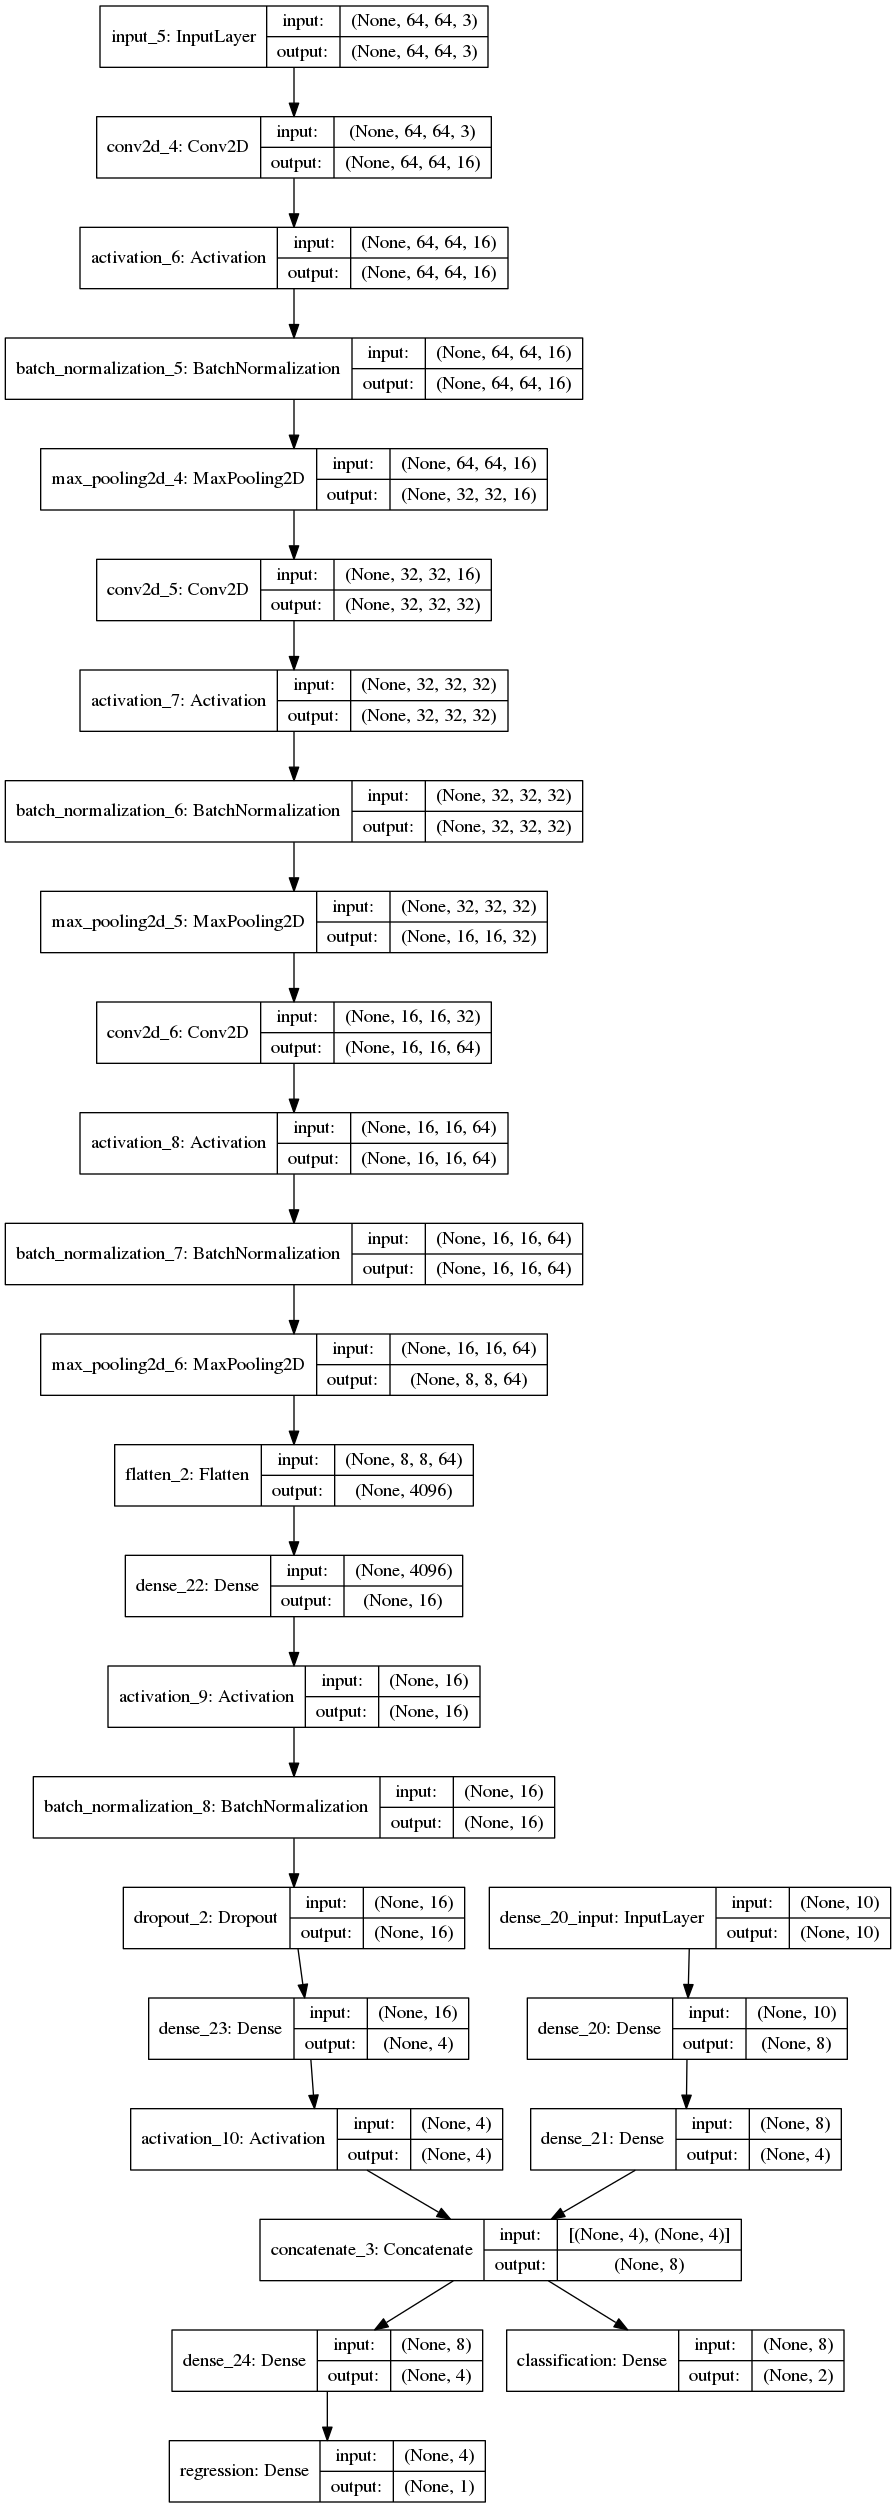

In [27]:
plot_model(model1, to_file='model2.png', show_shapes='True')

## 4 loss definition and model compilation

In [28]:
losses = {
	"regression": "mean_squared_error",
	"classification": "binary_crossentropy",
}
lossWeights = {"regression": 1.0, "classification": 1.0}

opt = Adam(lr=1e-3, decay=1e-3 / 200)
model1.compile(optimizer=opt, loss=losses, loss_weights=lossWeights, metrics=["accuracy"])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## 5 model training

In [29]:
# train the model
print("[INFO] training model...")

hist1 = model1.fit(
    [trainAttrX, trainImagesX], [trainY,trainYY],
    validation_data=([testAttrX, testImagesX], [testY,testYY]),
    epochs=50, batch_size=8)

[INFO] training model...
Train on 271 samples, validate on 91 samples
Epoch 1/50
271/271 [==============================] - 2s 6ms/step - loss: 1.3075 - regression_loss: 0.7022 - classification_loss: 0.6051 - regression_accuracy: 0.3321 - classification_accuracy: 0.6679 - val_loss: 1.3850 - val_regression_loss: 0.7114 - val_classification_loss: 0.6836 - val_regression_accuracy: 0.2527 - val_classification_accuracy: 0.5000
Epoch 2/50
271/271 [==============================] - 1s 2ms/step - loss: 1.2040 - regression_loss: 0.6238 - classification_loss: 0.5808 - regression_accuracy: 0.3321 - classification_accuracy: 0.7103 - val_loss: 1.3456 - val_regression_loss: 0.6662 - val_classification_loss: 0.6868 - val_regression_accuracy: 0.2527 - val_classification_accuracy: 0.5000
Epoch 3/50
271/271 [==============================] - 1s 2ms/step - loss: 1.1265 - regression_loss: 0.5816 - classification_loss: 0.5450 - regression_accuracy: 0.3321 - classification_accuracy: 0.7103 - val_loss: 1.329

Epoch 24/50
271/271 [==============================] - 1s 3ms/step - loss: 0.1990 - regression_loss: 0.1158 - classification_loss: 0.0836 - regression_accuracy: 0.9631 - classification_accuracy: 0.9649 - val_loss: 0.3884 - val_regression_loss: 0.1326 - val_classification_loss: 0.2435 - val_regression_accuracy: 0.9451 - val_classification_accuracy: 0.9231
Epoch 25/50
271/271 [==============================] - 1s 3ms/step - loss: 0.1884 - regression_loss: 0.1079 - classification_loss: 0.0803 - regression_accuracy: 0.9594 - classification_accuracy: 0.9649 - val_loss: 0.4320 - val_regression_loss: 0.1271 - val_classification_loss: 0.2898 - val_regression_accuracy: 0.9341 - val_classification_accuracy: 0.9121
Epoch 26/50
271/271 [==============================] - 1s 3ms/step - loss: 0.1758 - regression_loss: 0.0997 - classification_loss: 0.0759 - regression_accuracy: 0.9631 - classification_accuracy: 0.9649 - val_loss: 0.3513 - val_regression_loss: 0.1164 - val_classification_loss: 0.2241 -

Epoch 47/50
271/271 [==============================] - 1s 3ms/step - loss: 0.0952 - regression_loss: 0.0406 - classification_loss: 0.0543 - regression_accuracy: 0.9594 - classification_accuracy: 0.9926 - val_loss: 0.6353 - val_regression_loss: 0.0630 - val_classification_loss: 0.5399 - val_regression_accuracy: 0.9341 - val_classification_accuracy: 0.9011
Epoch 48/50
271/271 [==============================] - 1s 3ms/step - loss: 0.0877 - regression_loss: 0.0403 - classification_loss: 0.0471 - regression_accuracy: 0.9594 - classification_accuracy: 0.9871 - val_loss: 0.6105 - val_regression_loss: 0.0599 - val_classification_loss: 0.5194 - val_regression_accuracy: 0.9341 - val_classification_accuracy: 0.9066
Epoch 49/50
271/271 [==============================] - 1s 3ms/step - loss: 0.0831 - regression_loss: 0.0385 - classification_loss: 0.0443 - regression_accuracy: 0.9594 - classification_accuracy: 0.9834 - val_loss: 0.5573 - val_regression_loss: 0.0623 - val_classification_loss: 0.4665 -

## 6 visualization

In [30]:
# list all data in history
print(hist1.history.keys())

dict_keys(['val_loss', 'val_regression_loss', 'val_classification_loss', 'val_regression_accuracy', 'val_classification_accuracy', 'loss', 'regression_loss', 'classification_loss', 'regression_accuracy', 'classification_accuracy'])


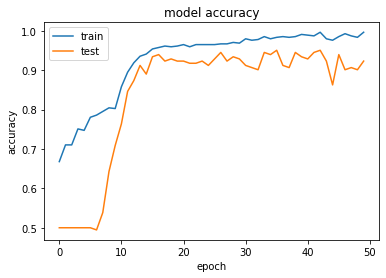

In [31]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.figure()
plt.plot(hist1.history['classification_accuracy'])
plt.plot(hist1.history['val_classification_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

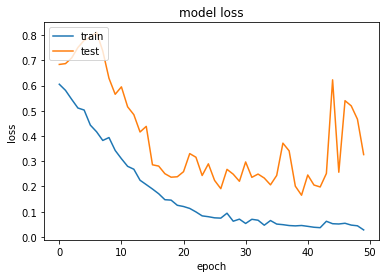

In [32]:
# summarize history for loss value
plt.figure()
plt.plot(hist1.history['classification_loss'])
plt.plot(hist1.history['val_classification_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## 7 prediction

In [33]:
# make predictions on the testing data
print("[INFO] predicting house prices...")
preds = model1.predict([testAttrX, testImagesX])

[INFO] predicting house prices...


## 8 results

### 8.1 regression results

In [34]:
# compute the difference between the *predicted* house prices and the
# *actual* house prices, then compute the percentage difference and
# the absolute percentage difference
diff = preds[0].flatten() - testY
percentDiff = (diff / testY) * 100
percentDiff[np.isinf(percentDiff)]=0
absPercentDiff = np.abs(percentDiff)

# compute the mean and standard deviation of the absolute percentage
# difference
mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)

# finally, show some statistics on our model
locale.setlocale(locale.LC_ALL, "en_US.UTF-8")
print("[INFO] avg. house price: {}, std house price: {}".format(
	locale.currency(df["price"].mean(), grouping=True),
	locale.currency(df["price"].std(), grouping=True)))
print("[INFO] mean: {:.2f}%, std: {:.2f}%".format(mean, std))

[INFO] avg. house price: $533,388.27, std house price: $493,403.08
[INFO] mean: 7.62%, std: 4.56%


### 8.2 classification results

In [35]:
loss_all, reg_loss, classi_loss, reg_acc, classi_acc = model1.evaluate([testAttrX, testImagesX], [testY,testYY])

print('Test accuracy:', classi_acc)

91/91 [==============================] - 0s 223us/step
Test accuracy: 0.9230769276618958
